# Hypothesis 3: As children gain experience with the task, they may become more efficient in their information-seeking strategies, which may lead to fewer mistakes

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, kruskal, sem, f_oneway
from sklearn.utils import resample
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

## Dataset

In [37]:
#Read the dataset and drop NaN values

dataset = 'dataset_accuracy.csv'
data_original = pd.read_csv(dataset)
data_original.dropna(inplace=True)

data_original['durLookBottom'] = data_original['LookTotDurInL'] + data_original['LookTotDurInR'] #New variable: durLookBottom

data_original['FixNbInBottom'] = data_original['FixNbInL'] + data_original['FixNbInR'] #New variable: FixNbInBottom

data_original['durfixBottom'] = data_original['FixTotDurInL'] + data_original['FixTotDurInR'] #New variable: durFixBottom

data_original

session  trialno difficulty  accuracy period_in_trial  step_reached  \
0     curE002a        8       Easy       0.0     exploration             3   
1     curE002a        8       Easy       0.0        decision             3   
2     curE002a        9       Easy       1.0     exploration             3   
3     curE002a        9       Easy       1.0        decision             3   
4     curE002a       10       Easy       1.0     exploration             3   
5     curE002a       10       Easy       1.0        decision             3   
6     curE002a       11     Medium       1.0     exploration             3   
7     curE002a       11     Medium       1.0        decision             3   
8     curE002a       12     Medium       0.0     exploration             3   
9     curE002a       12     Medium       0.0        decision             3   
10    curE002a       13     Medium       1.0     exploration             3   
11    curE002a       13     Medium       1.0        decision             3   
12    curE002a       14     Medium       0.0     exploration             3   
13    curE002a       14     Medium       0.0        decision             3   
14    curE002a       16     Medium       0.0     exploration             3   
15    curE002a       16     Medium       0.0        decision             3   
16    curE002a       19     Medium       0.0     exploration             3   
17    curE002a       19     Medium       0.0        decision             3   
18    curE002a       20     Medium       0.0     exploration             3   
19    curE002a       20     Medium       0.0        decision             3   
20    curE002a       21       Easy       1.0     exploration             3   
21    curE002a       21       Easy       1.0        decision             3   
22    curE002a       24       Easy       1.0     exploration             3   
23    curE002a       24       Easy       1.0        decision             3   
24    curE002a       25       Easy       1.0     exploration             3   
25    curE002a       25       Easy       1.0        decision             3   
26    curE004a        8       Easy       1.0     exploration             3   
27    curE004a        8       Easy       1.0        decision             3   
28    curE004a        9       Easy       1.0     exploration             3   
29    curE004a        9       Easy       1.0        decision             3   
30    curE004a       10     Medium       0.0     exploration             3   
31    curE004a       10     Medium       0.0        decision             3   
32    curE004a       13       Easy       0.0     exploration             3   
33    curE004a       13       Easy       0.0        decision             3   
34    curE004a       14       Easy       1.0     exploration             3   
35    curE004a       14       Easy       1.0        decision             3   
36    curE004a       15       Easy       1.0     exploration             3   
37    curE004a       15       Easy       1.0        decision             3   
38    curE004a       16     Medium       1.0     exploration             3   
39    curE004a       16     Medium       1.0        decision             3   
40    curE004a       21       Hard       1.0     exploration             3   
41    curE004a       21       Hard       1.0        decision             3   
42    curE004a       28     Medium       1.0     exploration             3   
43    curE004a       28     Medium       1.0        decision             3   
44    curE004a       29     Medium       0.0     exploration             3   
45    curE004a       29     Medium       0.0        decision             3   
46    curE004a       38       Easy       0.0     exploration             3   
47    curE004a       38       Easy       0.0        decision             3   
48    curE004a       41       Easy       1.0     exploration             3   
49    curE004a       41       Easy       1.0        decision             3   
50    curE004a       42      

In [38]:
# DF DATA PER TRIAL

# Exploration period duration
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
durExplorationTotal_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durPeriodTotal'].sum().reset_index()
durExplorationTotal_df.rename(columns={'durPeriodTotal': 'durExplorationPeriod'}, inplace=True)                                              

# Decision period duration
decision_df = data_original[data_original['period_in_trial'] == 'decision']
durDecisionTotal_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['durPeriodTotal'].sum().reset_index()
durDecisionTotal_df.rename(columns={'durPeriodTotal': 'durDecisionPeriod'}, inplace=True)

# Trial duration
trialduration_df = data_original.groupby(['session', 'trialno', 'difficulty'])['durPeriodTotal'].sum().reset_index()

# Accuracy
decision_df = data_original[data_original['period_in_trial'] == 'decision']
accuracy_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['accuracy'].sum().reset_index()

# Side Chosen
decision_df = data_original[data_original['period_in_trial'] == 'decision']
sideChosen_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['sideChosen'].sum().reset_index()

#Number of switches during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
SwitchesExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()
SwitchesExploration_df.rename(columns={'NbSwitches': 'SwitchesExplorationPeriod'}, inplace=True)   

#Number of switches during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
SwitchesDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()
SwitchesDecision_df.rename(columns={'NbSwitches': 'SwitchesDecisionPeriod'}, inplace=True)   

#Number of switches in total
SwitchesTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()

#Fixation number during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixNbExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()
FixNbExploration_df.rename(columns={'FixNb': 'FixNbExplorationPeriod'}, inplace=True)   

#Fixation number during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixNbDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()
FixNbDecision_df.rename(columns={'FixNb': 'FixNbDecisionPeriod'}, inplace=True)   

#Fixation number in total
FixNbTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()

#Fixation number in top card during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixNbTD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()
FixNbTD_df.rename(columns={'FixNbInT': 'FixNbInTDecision'}, inplace=True)   

#Fixation number in top card during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixNbTE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()
FixNbTE_df.rename(columns={'FixNbInT': 'FixNbInTExploration'}, inplace=True) 

#Fixation number in Bottom cards during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixNbBottom_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInBottom'].sum().reset_index()
FixNbBottom_df.rename(columns={'FixNbInBottom': 'FixNbInBottomExploration'}, inplace=True)

#Fixation number in Bottom during both periods
FixNbBottomTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixNbInBottom'].sum().reset_index()

#Fixation number in Top during both periods
FixNbInTTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()

# Look total duration in top card during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
LookDurTDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()
LookDurTDecision_df.rename(columns={'LookTotDurInT': 'LookDurInTDecision'}, inplace=True)   

# Look total duration in top card during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'decision']
LookDurTExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()
LookDurTExploration_df.rename(columns={'LookTotDurInT': 'LookDurInTExploration'}, inplace=True)  

# Look total duration in bottom cards during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
LookDurBE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()
LookDurBE_df.rename(columns={'durLookBottom': 'durLookBottomExploration'}, inplace=True)

# Look total duration in bottom cards during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
LookDurBD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()
LookDurBD_df.rename(columns={'durLookBottom': 'durLookBottomDecision'}, inplace=True)

# Look total duration in Bottom cards during both periods
LookDurBottomTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()

# Look total duration in Top Card during both periods
LookDurTopTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()

# Fixation duration of top card during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixDurTDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()
FixDurTDecision_df.rename(columns={'FixTotDurInT': 'FixDurInTDecision'}, inplace=True)   

# Fixation duration of top card during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'decision']
FixDurTExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()
FixDurTExploration_df.rename(columns={'FixTotDurInT': 'FixDurInTExploration'}, inplace=True)  

# Fixation duration of bottom cards during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixDurBE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()
FixDurBE_df.rename(columns={'durfixBottom': 'durfixBottomExploration'}, inplace=True)

# Fixation duration of bottom cards during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixDurBD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()
FixDurBD_df.rename(columns={'durfixBottom': 'durfixBottomDecision'}, inplace=True)

# Fixation duration of Bottom cards during both periods
FixDurBottomTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()

# Fixation duration of Top card during both periods
FixDurTopTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()

merged_filtered_data = accuracy_df.merge(sideChosen_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(trialduration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(durExplorationTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(durDecisionTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(SwitchesTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(SwitchesExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(SwitchesDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(FixNbExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbBottom_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbInTTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(LookDurTDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurTExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurTopTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')


merged_filtered_data = merged_filtered_data.merge(FixDurTDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurTExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurTopTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data

session  trialno difficulty  accuracy sideChosen  durPeriodTotal  \
0     curE002a        8       Easy       0.0       left           12194   
1     curE002a        9       Easy       1.0       left            4680   
2     curE002a       10       Easy       1.0      right           12826   
3     curE002a       11     Medium       1.0      right            3910   
4     curE002a       12     Medium       0.0       left           15256   
5     curE002a       13     Medium       1.0       left           15846   
6     curE002a       14     Medium       0.0       left            6926   
7     curE002a       16     Medium       0.0       left            4478   
8     curE002a       19     Medium       0.0       left            7128   
9     curE002a       20     Medium       0.0      right            9080   
10    curE002a       21       Easy       1.0       left            7046   
11    curE002a       24       Easy       1.0      right            6430   
12    curE002a       25       Easy       1.0      right            5098   
13    curE004a        8       Easy       1.0       left           10108   
14    curE004a        9       Easy       1.0       left            4850   
15    curE004a       10     Medium       0.0       left           12544   
16    curE004a       13       Easy       0.0      right            6314   
17    curE004a       14       Easy       1.0      right            5698   
18    curE004a       15       Easy       1.0       left           21272   
19    curE004a       16     Medium       1.0      right            8030   
20    curE004a       21       Hard       1.0       left            6344   
21    curE004a       28     Medium       1.0       left           11112   
22    curE004a       29     Medium       0.0       left            5308   
23    curE004a       38       Easy       0.0       left           16760   
24    curE004a       41       Easy       1.0      right            7948   
25    curE004a       42       Easy       1.0       left            3728   
26    curE004a       45     Medium       1.0      right           10542   
27    curE004a       46     Medium       0.0       left            4898   
28    curE004a       47     Medium       0.0      right            6658   
29    curE004a       52       Easy       0.0      right           10180   
30    curE004a       53       Easy       1.0       left            7808   
31    curE004a       54       Easy       0.0       left            3092   
32    curE004a       55       Easy       0.0      right           16510   
33    curE004a       56       Easy       1.0       left           14574   
34    curE004a       57       Easy       0.0       left            6948   
35    curE004a       58       Easy       0.0       left            9978   
36    curE004a       64       Easy       0.0       left           11594   
37    curE004a       65       Easy       1.0       left           14604   
38    curE008a        9       Easy       0.0      right           17042   
39    curE008a       10       Easy       0.0       left           12808   
40    curE008a       11       Easy       1.0       left            8930   
41    curE008a       12       Easy       1.0       left            9298   
42    curE008a       13     Medium       1.0       left           13062   
43    curE008a       14     Medium       0.0       left           15094   
44    curE008a       15     Medium       0.0       left            7228   
45    curE008a       17       Easy       0.0      right            8564   
46    curE008a       18       Easy       1.0       left           17410   
47    curE008a       20       Easy       0.0       left           16376   
48    curE008a       21       Easy       0.0       left            5198   
49    curE008a       25       Easy       1.0      right            5214   
50    curE009a        9       Easy       1.0       left            6830   
51    curE009a       10       Easy       1.0      right           11908   
52    curE009a       11     Medi

In [39]:
filtered_data = merged_filtered_data.dropna() 
filtered_data

filtered_data.sort_values(by=['session', 'trialno'], inplace=True)

mask = (
    (filtered_data['trialno'].shift(1) == filtered_data['trialno'] - 1) |  # Check if the trialno is preceded by the previous trialno
    (filtered_data['trialno'].shift(-1) == filtered_data['trialno'] + 1) | # Check if the trialno is followed by a consecutive trialno
    (filtered_data['trialno'].shift(1).isna()) |               # Check if the trialno has no previous trialno
    (filtered_data['trialno'].shift(-1).isna())                # Check if the trialno has no following trialno
)

data = filtered_data[mask]

data['prior_accuracy'] = data.groupby('session')['accuracy'].shift(1)

data.loc[~(data['trialno'] - 1 == data['trialno'].shift(1)), 'prior_accuracy'] = float('NaN')

data.reset_index(drop=True, inplace=True)

data = data.drop(data.index[-1])

data

session  trialno difficulty  accuracy sideChosen  durPeriodTotal  \
0    curE002a        8       Easy       0.0       left           12194   
1    curE002a        9       Easy       1.0       left            4680   
2    curE002a       10       Easy       1.0      right           12826   
3    curE002a       11     Medium       1.0      right            3910   
4    curE002a       12     Medium       0.0       left           15256   
5    curE002a       13     Medium       1.0       left           15846   
6    curE002a       14     Medium       0.0       left            6926   
7    curE002a       19     Medium       0.0       left            7128   
8    curE002a       20     Medium       0.0      right            9080   
9    curE002a       21       Easy       1.0       left            7046   
10   curE002a       24       Easy       1.0      right            6430   
11   curE002a       25       Easy       1.0      right            5098   
12   curE004a        8       Easy       1.0       left           10108   
13   curE004a        9       Easy       1.0       left            4850   
14   curE004a       10     Medium       0.0       left           12544   
15   curE004a       13       Easy       0.0      right            6314   
16   curE004a       14       Easy       1.0      right            5698   
17   curE004a       15       Easy       1.0       left           21272   
18   curE004a       16     Medium       1.0      right            8030   
19   curE004a       28     Medium       1.0       left           11112   
20   curE004a       29     Medium       0.0       left            5308   
21   curE004a       41       Easy       1.0      right            7948   
22   curE004a       42       Easy       1.0       left            3728   
23   curE004a       45     Medium       1.0      right           10542   
24   curE004a       46     Medium       0.0       left            4898   
25   curE004a       47     Medium       0.0      right            6658   
26   curE004a       52       Easy       0.0      right           10180   
27   curE004a       53       Easy       1.0       left            7808   
28   curE004a       54       Easy       0.0       left            3092   
29   curE004a       55       Easy       0.0      right           16510   
30   curE004a       56       Easy       1.0       left           14574   
31   curE004a       57       Easy       0.0       left            6948   
32   curE004a       58       Easy       0.0       left            9978   
33   curE004a       64       Easy       0.0       left           11594   
34   curE004a       65       Easy       1.0       left           14604   
35   curE008a        9       Easy       0.0      right           17042   
36   curE008a       10       Easy       0.0       left           12808   
37   curE008a       11       Easy       1.0       left            8930   
38   curE008a       12       Easy       1.0       left            9298   
39   curE008a       13     Medium       1.0       left           13062   
40   curE008a       14     Medium       0.0       left           15094   
41   curE008a       15     Medium       0.0       left            7228   
42   curE008a       17       Easy       0.0      right            8564   
43   curE008a       18       Easy       1.0       left           17410   
44   curE008a       20       Easy       0.0       left           16376   
45   curE008a       21       Easy       0.0       left            5198   
46   curE009a        9       Easy       1.0       left            6830   
47   curE009a       10       Easy       1.0      right           11908   
48   curE009a       11     Medium       0.0       left           12756   
49   curE009a       12     Medium       0.0       left            7880   
50   curE009a       14       Easy       1.0      right            4742   
51   curE009a       15       Easy       1.0      right            6498   
52   curE009a       16     Medium       1.0       left            5492   
53   curE0

## Improvement for each variable depending on prior accuracy

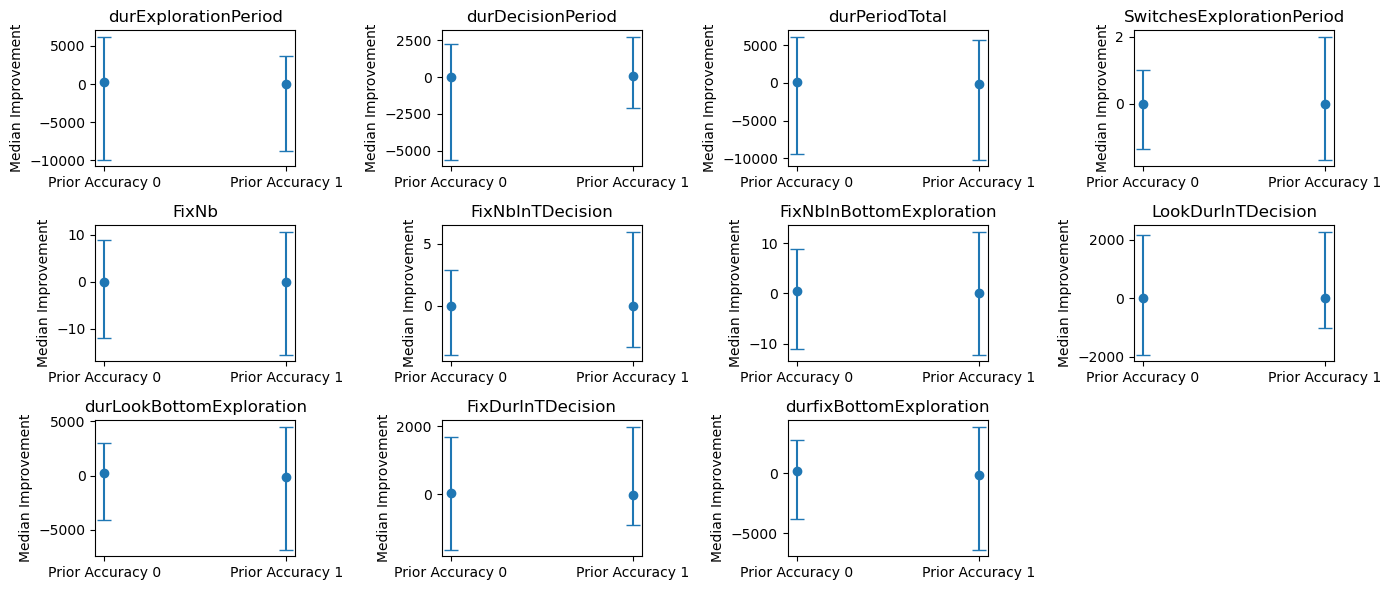

Variable: durExplorationPeriod
  Prior Accuracy = 0: Median Improvement = 230.0, Mean Improvement = 250.90975467569038
  Prior Accuracy = 1: Median Improvement = 0.0, Mean Improvement = 28.97950991411765

Variable: durDecisionPeriod
  Prior Accuracy = 0: Median Improvement = 20.5, Mean Improvement = -14.472601959444075
  Prior Accuracy = 1: Median Improvement = 60.0, Mean Improvement = 22.67893287888325

Variable: durPeriodTotal
  Prior Accuracy = 0: Median Improvement = 174.0, Mean Improvement = 236.43715271624637
  Prior Accuracy = 1: Median Improvement = -177.0, Mean Improvement = 51.658442793000894

Variable: SwitchesExplorationPeriod
  Prior Accuracy = 0: Median Improvement = 0.0, Mean Improvement = -0.09676625626918024
  Prior Accuracy = 1: Median Improvement = 0.0, Mean Improvement = 0.13394310367994577

Variable: FixNb
  Prior Accuracy = 0: Median Improvement = 0.0, Mean Improvement = -0.20147605264564325
  Prior Accuracy = 1: Median Improvement = 0.0, Mean Improvement = 0.1989

In [12]:
# Check, in general, if sessions tend to improve for each variable depending on prior accuracy
# Perform Kurskal-Wallis test for each variable.
variables = [
    'durExplorationPeriod',
    'durDecisionPeriod',
    'durPeriodTotal',
    'SwitchesExplorationPeriod',
    'FixNb',
    'FixNbInTDecision', 
    'FixNbInBottomExploration',
    'LookDurInTDecision', 
    'durLookBottomExploration', 
    'FixDurInTDecision', 
    'durfixBottomExploration'
]

improvement_0_medians = []
improvement_1_medians = []
improvement_0_means = []
improvement_1_means = []

confidence_level = 0.95

# Plots
plt.figure(figsize=(14, 6))

for i, variable in enumerate(variables, start=1):
    data[f'{variable}_diff'] = data.groupby('session')[variable].diff()

    median_diff_per_session_0 = data[data['prior_accuracy'] == 0].groupby('session')[f'{variable}_diff'].median()
    median_diff_per_session_1 = data[data['prior_accuracy'] == 1].groupby('session')[f'{variable}_diff'].median()

    mean_diff_per_session_0 = data[data['prior_accuracy'] == 0].groupby('session')[f'{variable}_diff'].mean()
    mean_diff_per_session_1 = data[data['prior_accuracy'] == 1].groupby('session')[f'{variable}_diff'].mean()

    improvement_0_median = np.median(median_diff_per_session_0)
    improvement_1_median = np.median(median_diff_per_session_1)
    improvement_0_mean = np.mean(mean_diff_per_session_0)
    improvement_1_mean = np.mean(mean_diff_per_session_1)
    
    improvement_0_medians.append(improvement_0_median)
    improvement_1_medians.append(improvement_1_median)
    improvement_0_means.append(improvement_0_mean)
    improvement_1_means.append(improvement_1_mean)

    _, p_value = kruskal(median_diff_per_session_0, median_diff_per_session_1)

    ci_0 = np.percentile(median_diff_per_session_0, [100 * (1 - confidence_level) / 2, 100 * (1 + confidence_level) / 2])
    ci_1 = np.percentile(median_diff_per_session_1, [100 * (1 - confidence_level) / 2, 100 * (1 + confidence_level) / 2])

    plt.subplot(3, 4, i)
    plt.errorbar(x=[0, 1], y=[improvement_0_median, improvement_1_median],
                 yerr=[[improvement_0_median - ci_0[0], ci_0[1] - improvement_0_median],
                       [improvement_1_median - ci_1[0], ci_1[1] - improvement_1_median]],
                 fmt='o', capsize=5)
    plt.title(variable)
    plt.xticks([0, 1], ['Prior Accuracy 0', 'Prior Accuracy 1'])
    plt.ylabel('Median Improvement')
    
plt.tight_layout()
plt.show()

# Mean and median improvement
for variable, median_0, median_1, mean_0, mean_1 in zip(variables, improvement_0_medians, improvement_1_medians, improvement_0_means, improvement_1_means):
    print(f'Variable: {variable}')
    print(f'  Prior Accuracy = 0: Median Improvement = {median_0}, Mean Improvement = {mean_0}')
    print(f'  Prior Accuracy = 1: Median Improvement = {median_1}, Mean Improvement = {mean_1}')
    print()

In [26]:
# Dataset with difference among variables trial by trial

variables = ['accuracy', 'durExplorationPeriod', 'durDecisionPeriod', 'durPeriodTotal',
             'SwitchesExplorationPeriod',   'SwitchesDecisionPeriod', 'NbSwitches', 'FixNb', 
             'FixNbInTDecision', 'FixNbInBottomExploration','LookDurInTDecision', 'durLookBottomExploration', 
             'FixDurInTDecision', 'durfixBottomExploration']

for variable in variables:
    data[f'{variable}_improvement'] = (data.groupby('session')[variable]
                                      .diff()
                                      .where((data['trialno'].shift(1) == data['trialno'] - 1) |
                                             (data['trialno'].shift(-1) == data['trialno'] + 1) |
                                             (data['trialno'].shift(1).isna()) |
                                             (data['trialno'].shift(-1).isna()))
                                    )
    
for variable in variables:
    data.loc[data['trialno'] == 1, f'{variable}_improvement'] = pd.NA

data.head()

session  trialno difficulty  accuracy sideChosen  durPeriodTotal  \
0  curE002a        8       Easy       0.0       left           12194   
1  curE002a        9       Easy       1.0       left            4680   
2  curE002a       10       Easy       1.0      right           12826   
3  curE002a       11     Medium       1.0      right            3910   
4  curE002a       12     Medium       0.0       left           15256   

   durExplorationPeriod  durDecisionPeriod  NbSwitches  \
0                 11270                924           6   
1                  2498               2182           2   
2                  9912               2914           4   
3                  2328               1582           3   
4                 14272                984           6   

   SwitchesExplorationPeriod  ...  SwitchesExplorationPeriod_improvement  \
0                          6  ...                                    NaN   
1                          2  ...                                   -4.0   
2                          3  ...                                    1.0   
3                          2  ...                                   -1.0   
4                          5  ...                                    3.0   

   SwitchesDecisionPeriod_improvement  NbSwitches_improvement  \
0                                 NaN                     NaN   
1                                 0.0                    -4.0   
2                                 1.0                     2.0   
3                                 0.0                    -1.0   
4                                 0.0                     3.0   

   FixNb_improvement  FixNbInTDecision_improvement  \
0                NaN                           NaN   
1              -12.0                           2.0   
2                7.0                           0.0   
3               -7.0                           0.0   
4               16.0                          -2.0   

   FixNbInBottomExploration_improvement  LookDurInTDecision_improvement  \
0                                   NaN                             NaN   
1                                 -13.0                          1346.0   
2                                   3.0                          -718.0   
3                                  -5.0                           -96.0   
4                                  18.0                          -424.0   

   durLookBottomExploration_improvement  FixDurInTDecision_improvement  \
0                                   NaN                            NaN   
1                               -3810.0                         1168.0   
2                                 988.0                         -668.0   
3                               -1664.0                         -152.0   
4                                6560.0                         -240.0   

   durfixBottomExploration_improvement  
0                                  NaN  
1                              -3484.0  
2                               1078.0  
3                              -1586.0  
4                               6088.0  

[5 rows x 46 columns]

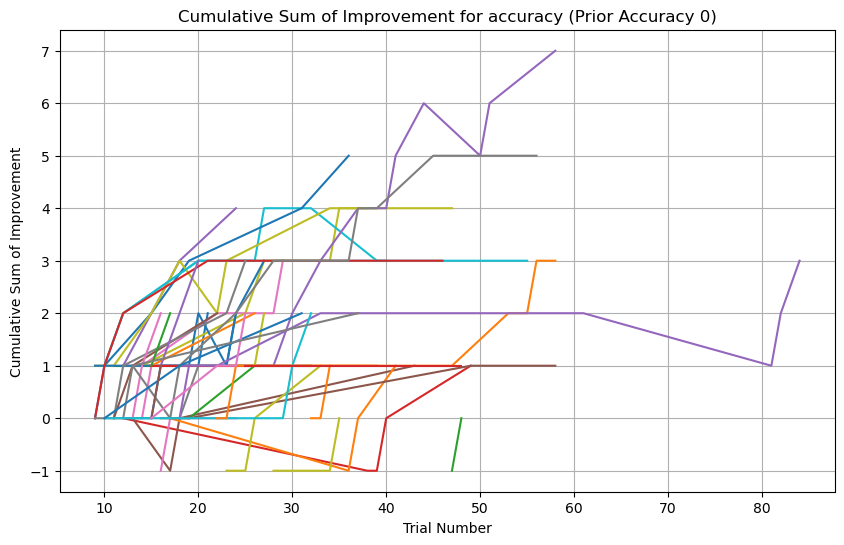

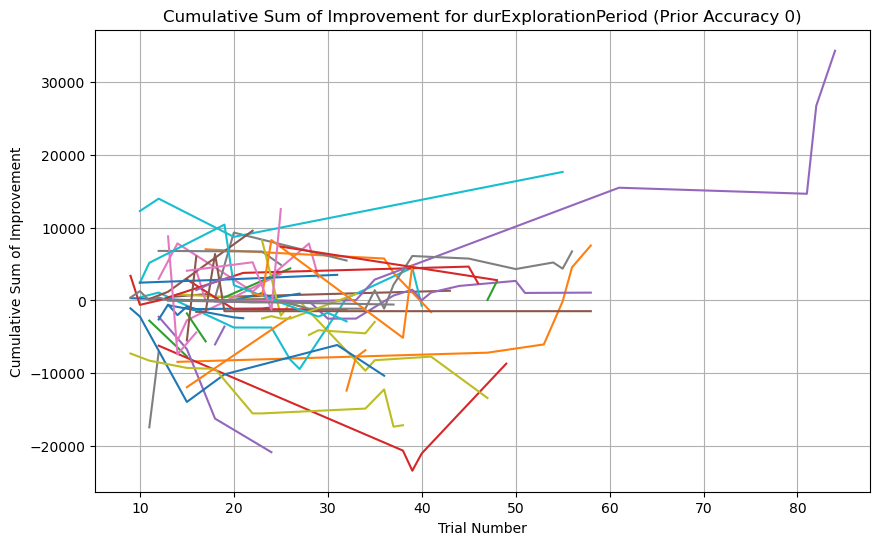

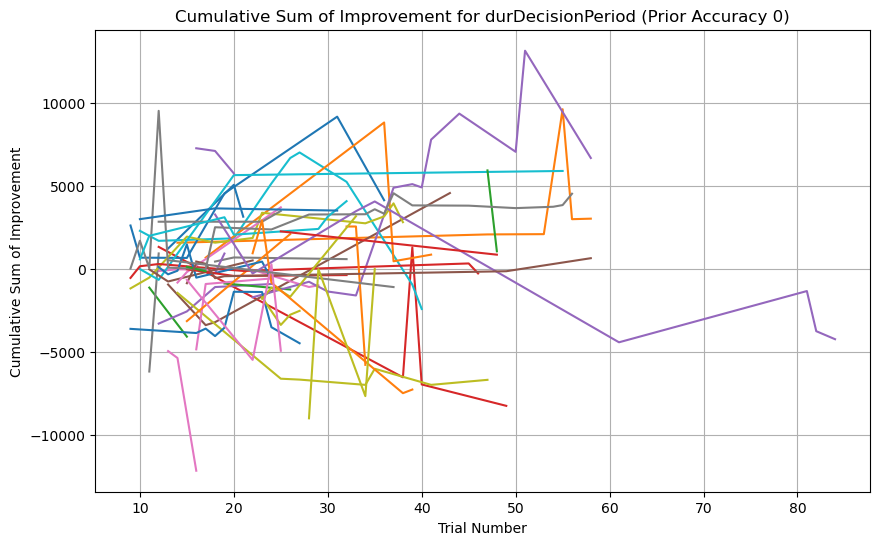

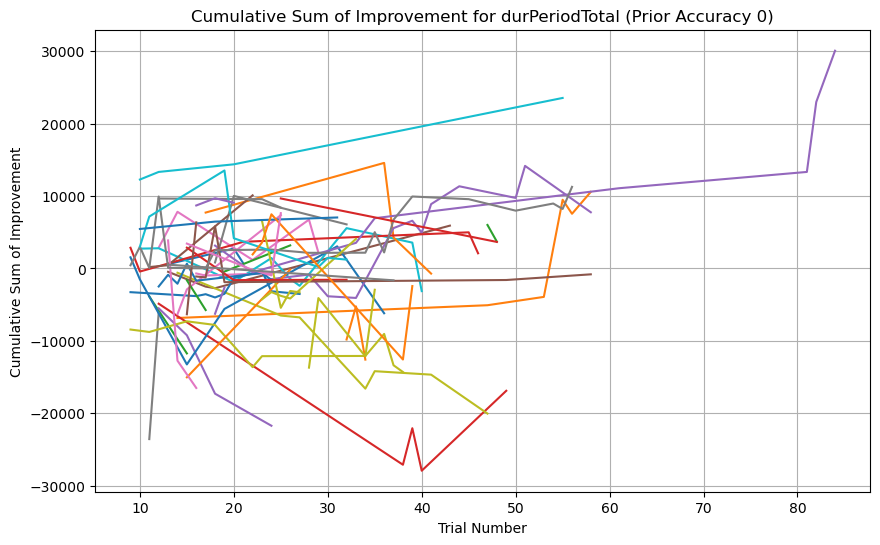

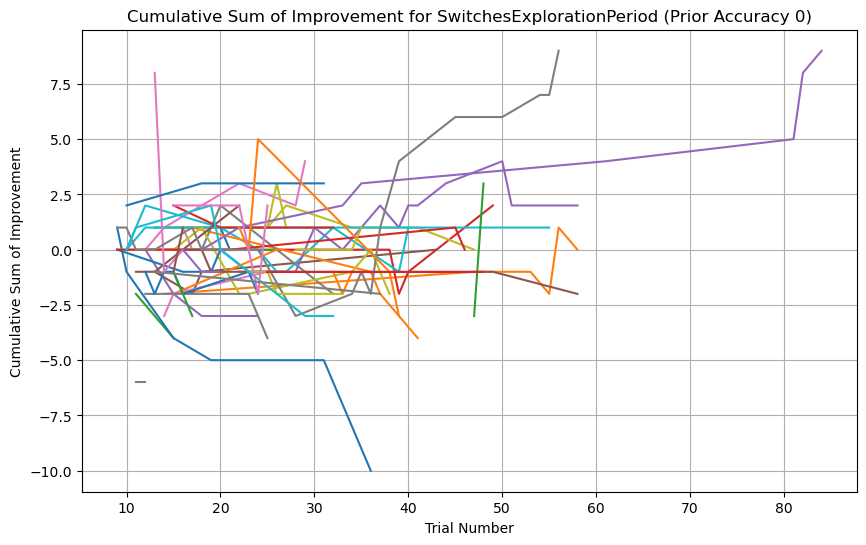

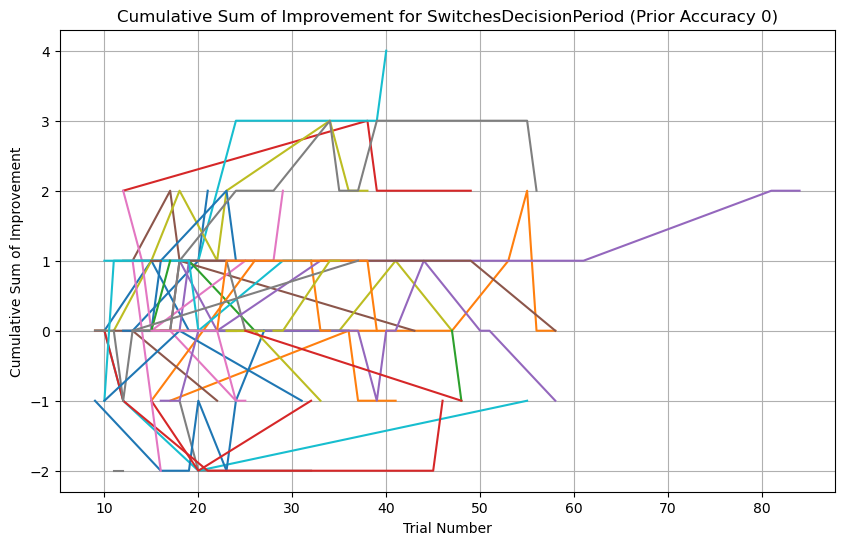

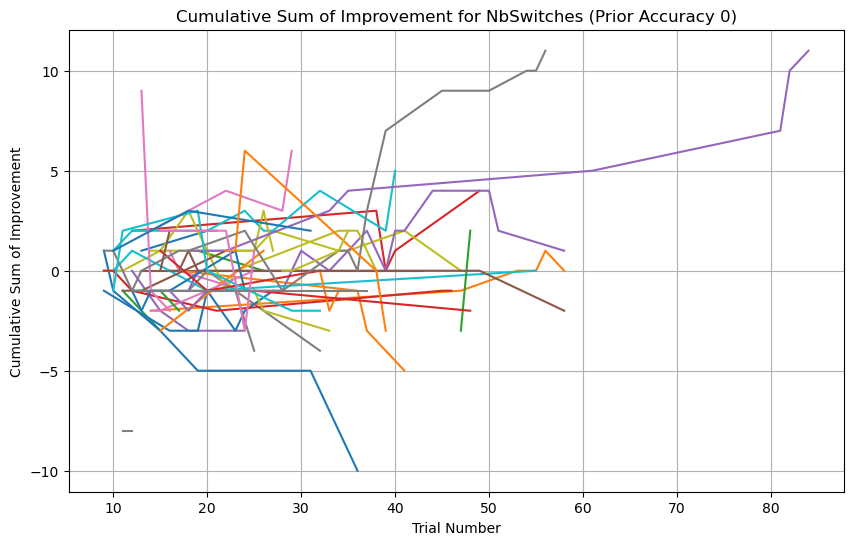

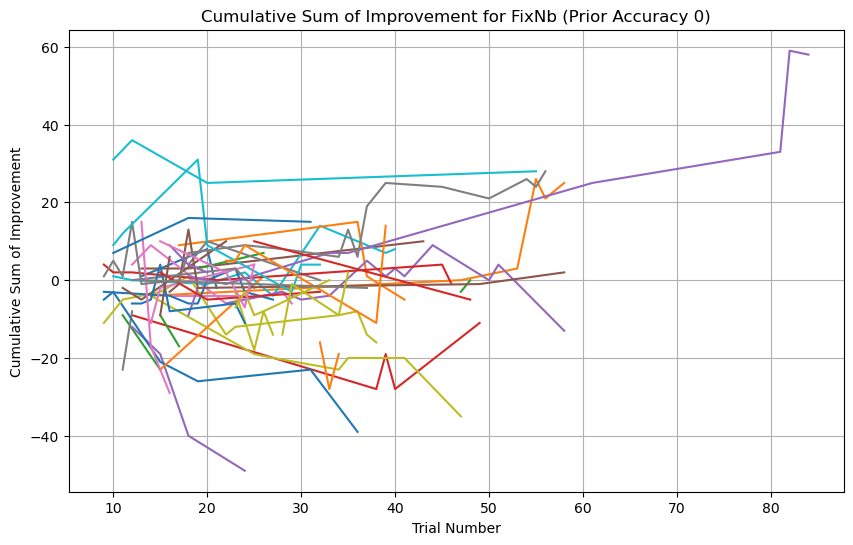

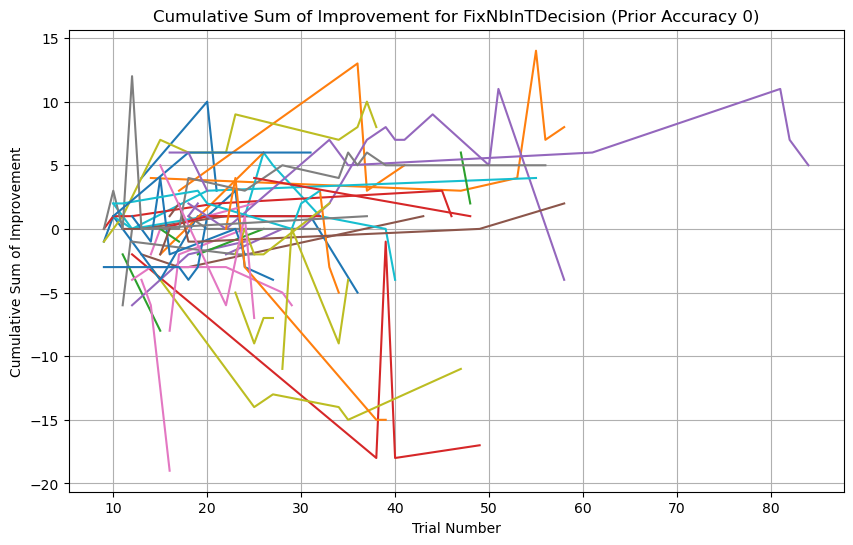

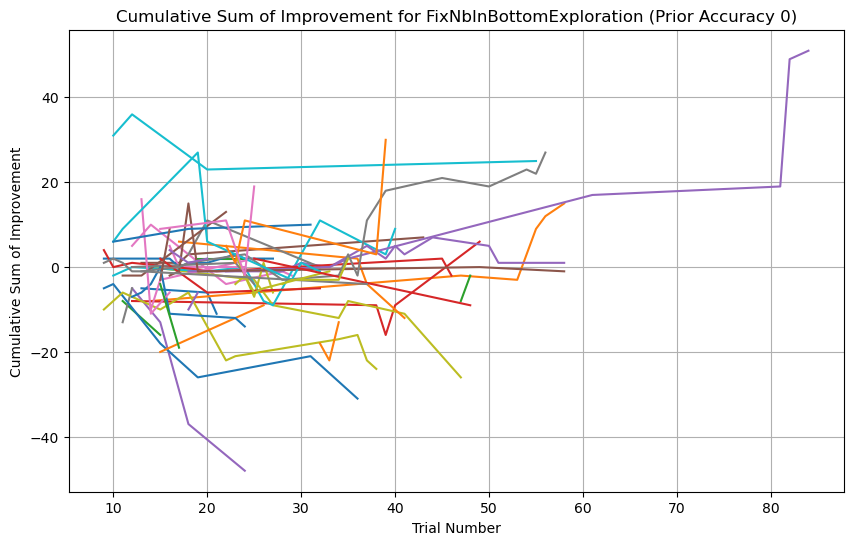

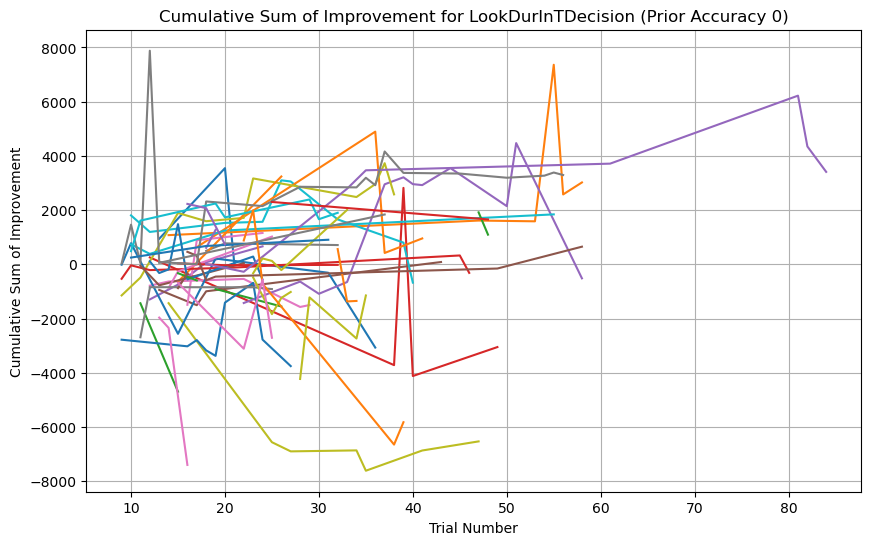

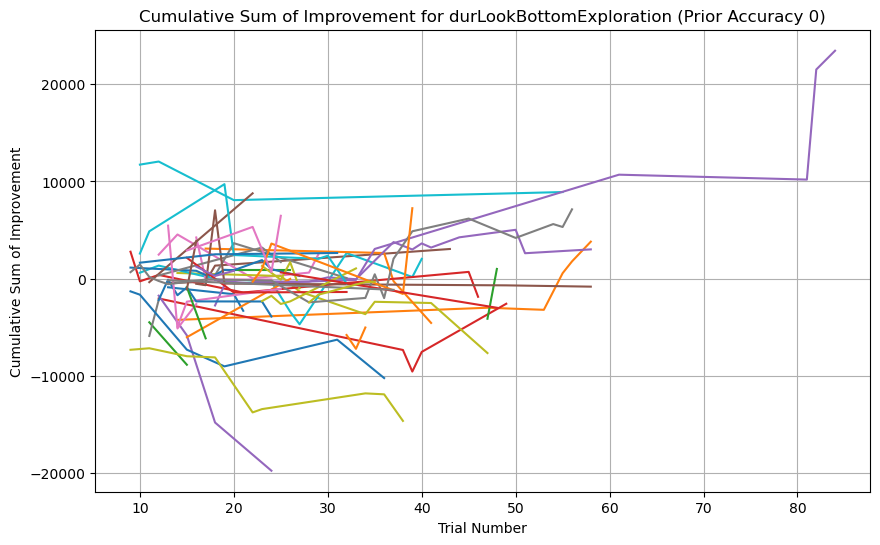

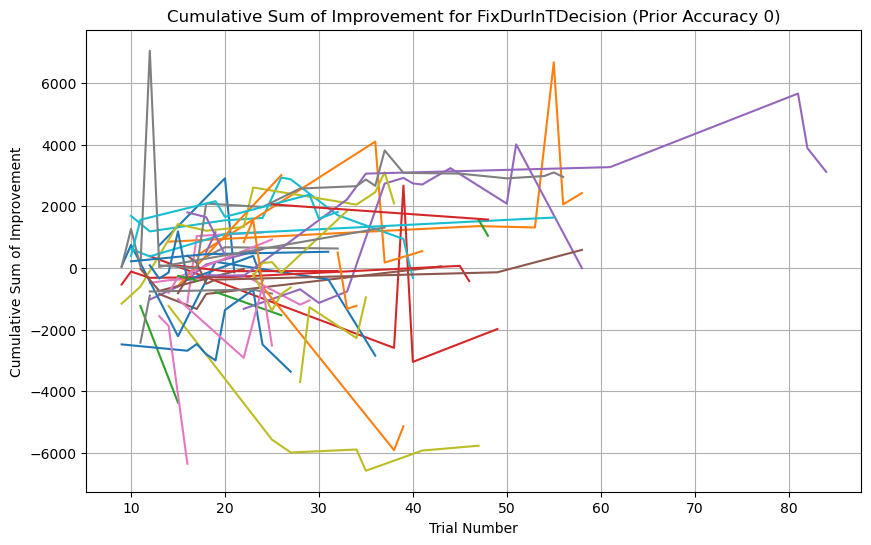

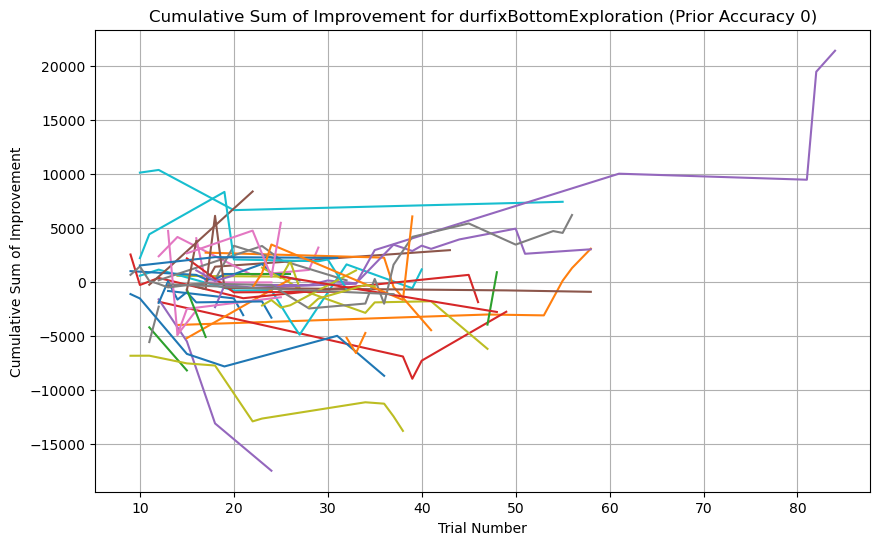

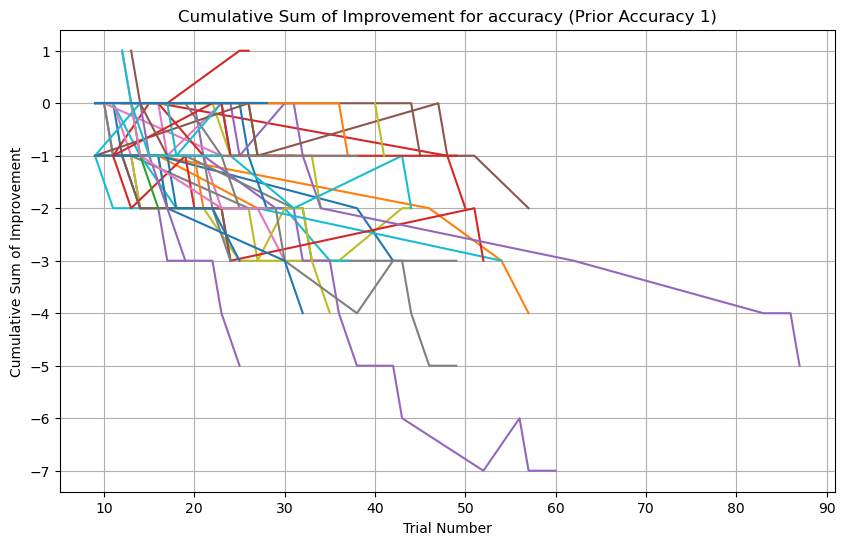

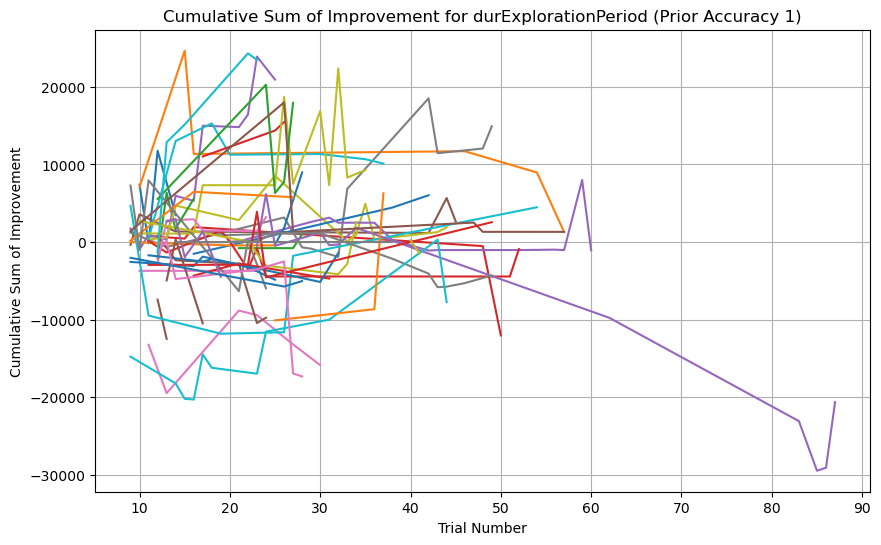

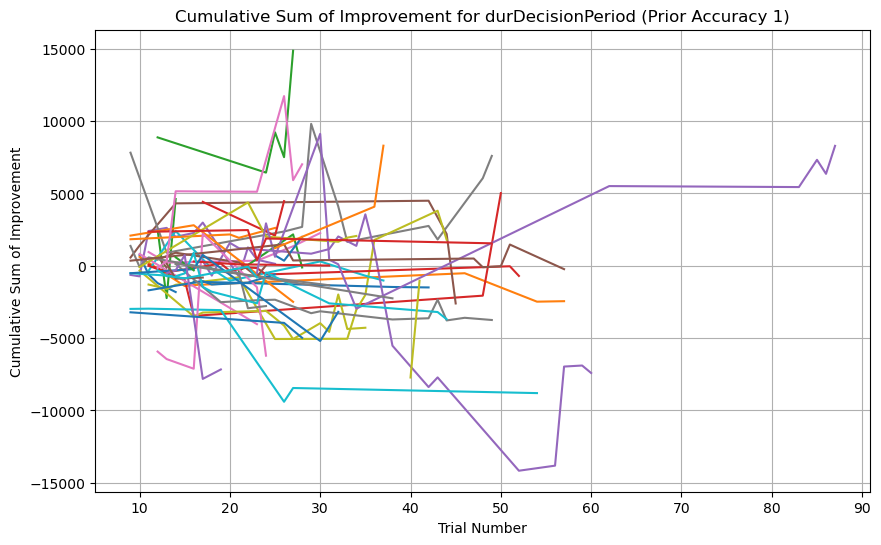

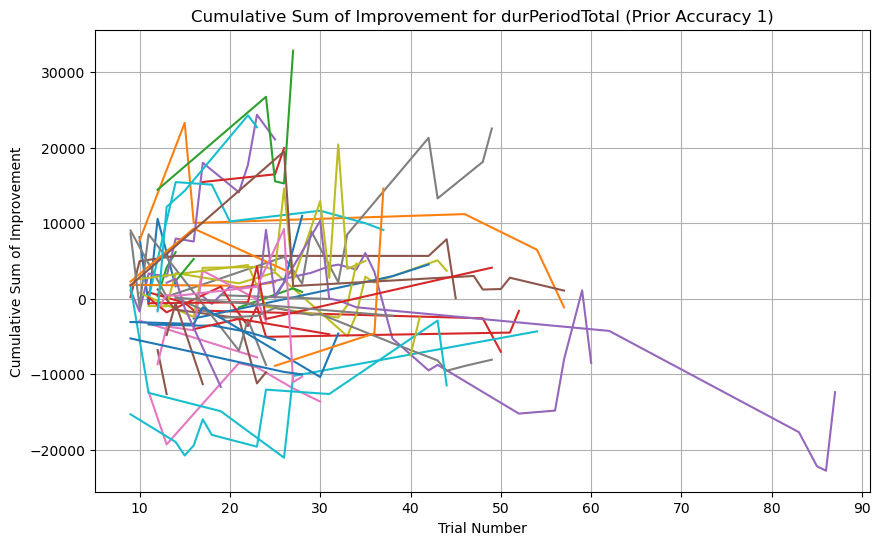

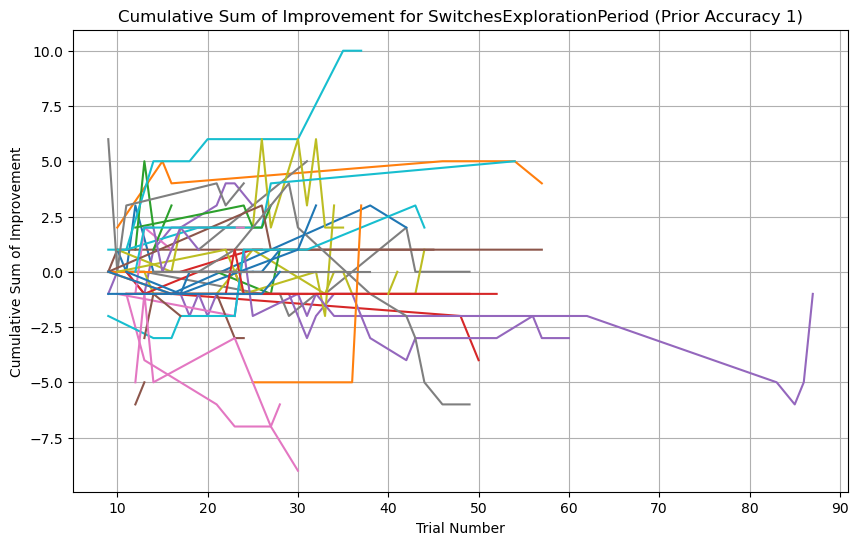

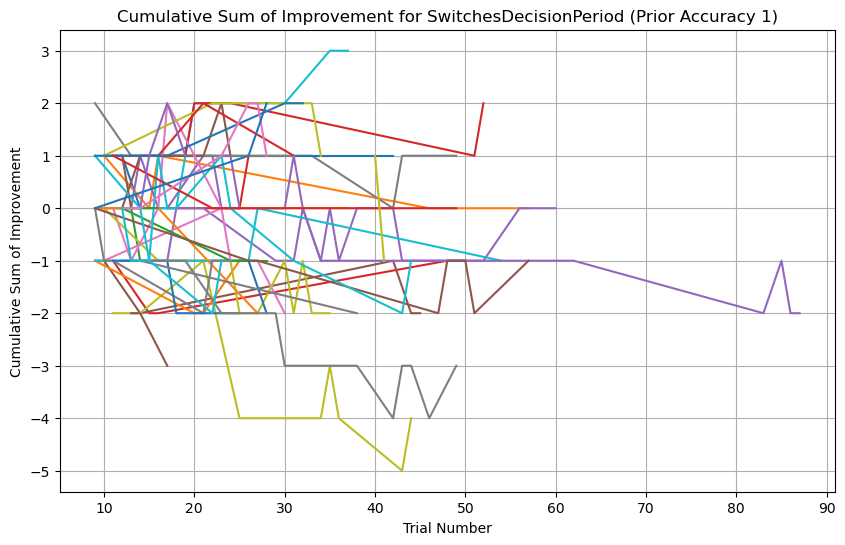

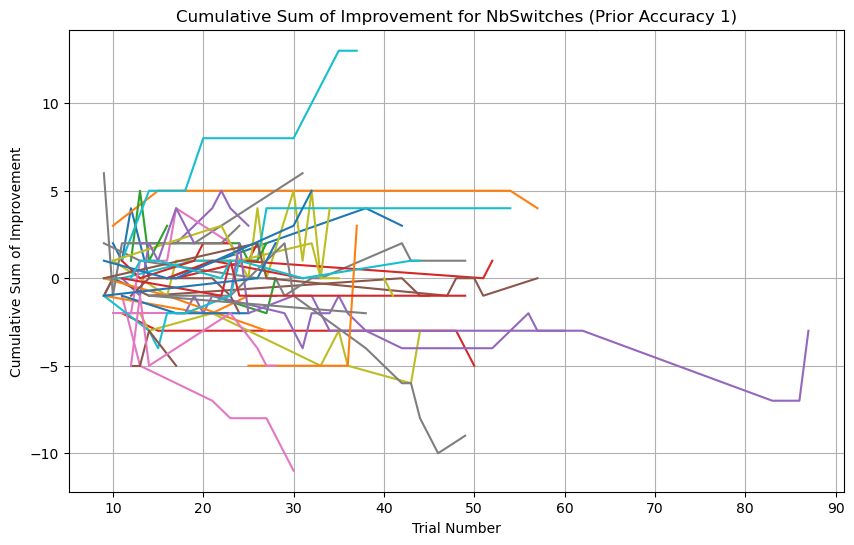

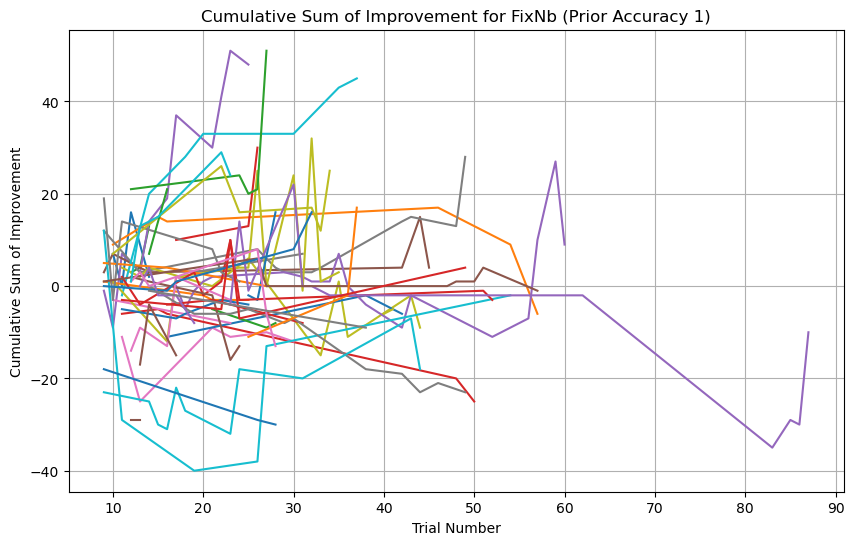

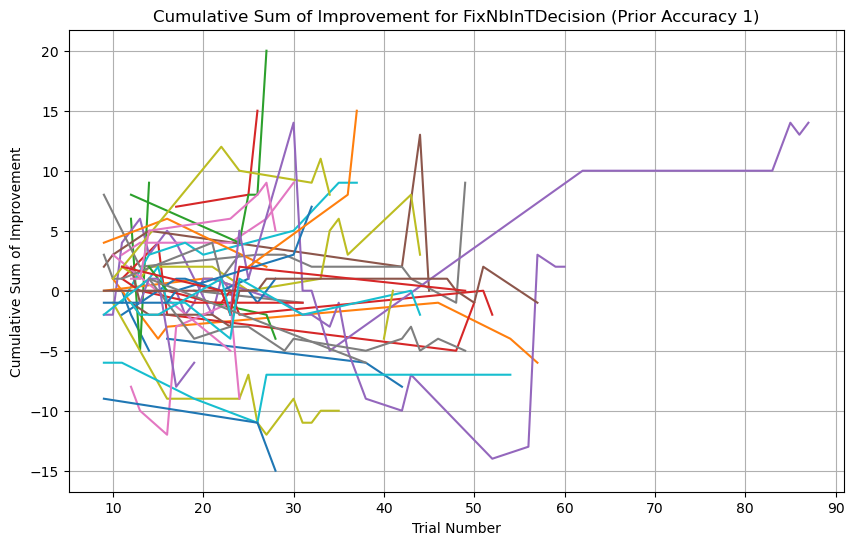

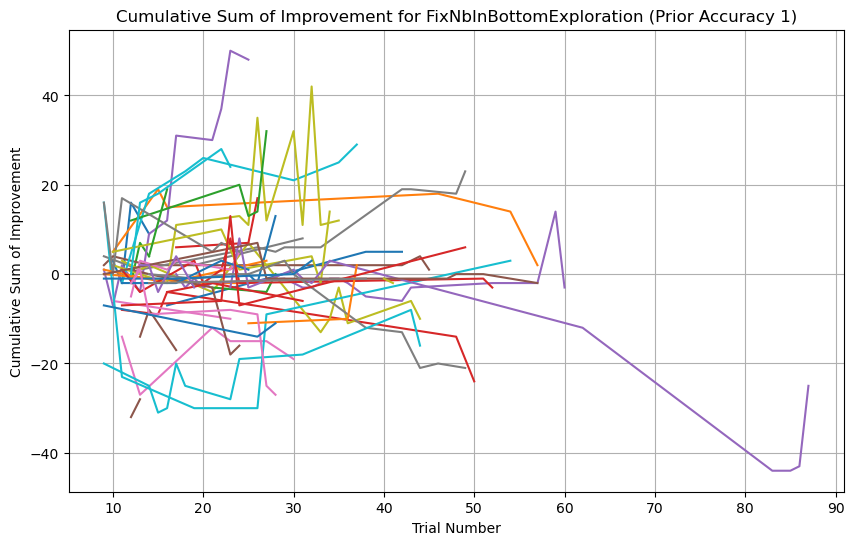

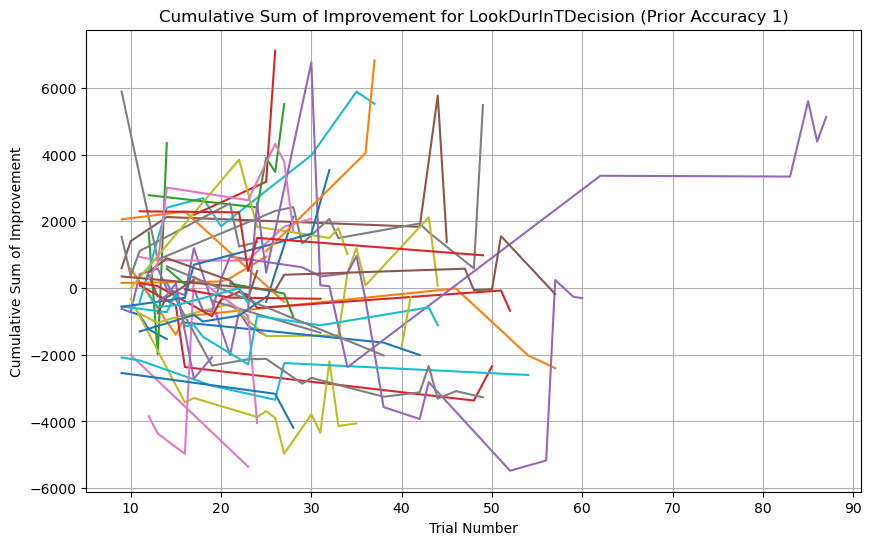

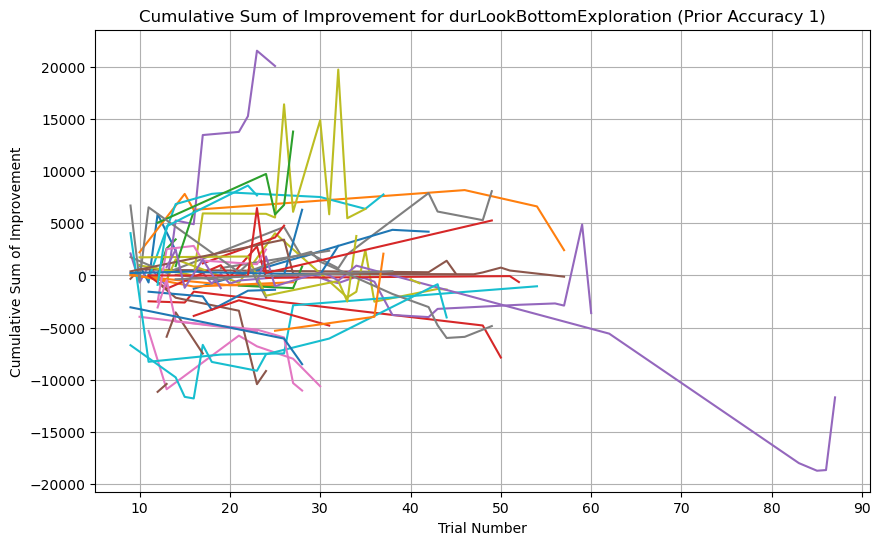

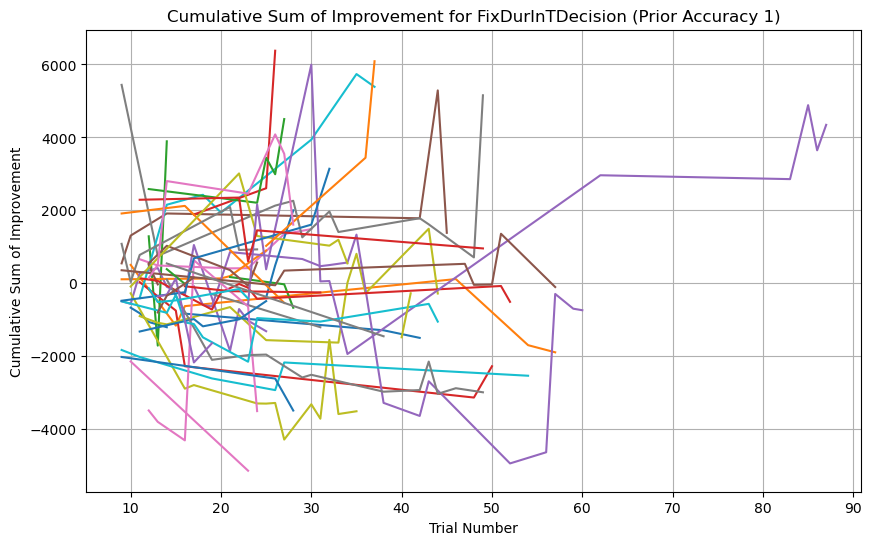

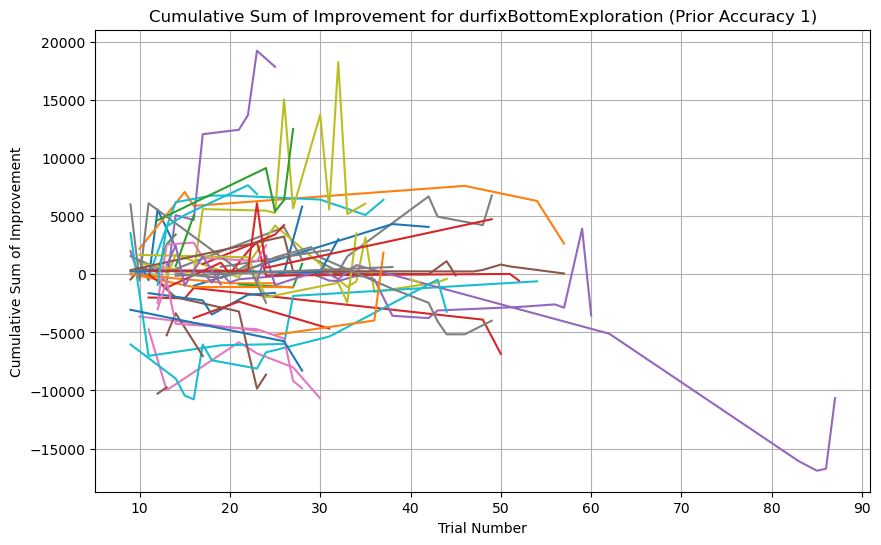

In [16]:
#Compute cumulative sum of improvements by prior accuracy

variables = ['accuracy', 'durExplorationPeriod', 'durDecisionPeriod', 'durPeriodTotal',
             'SwitchesExplorationPeriod',   'SwitchesDecisionPeriod', 'NbSwitches', 'FixNb', 
             'FixNbInTDecision', 'FixNbInBottomExploration','LookDurInTDecision', 'durLookBottomExploration', 
             'FixDurInTDecision', 'durfixBottomExploration']

prior_accuracy_0 = data[data['prior_accuracy'] == 0]
prior_accuracy_1 = data[data['prior_accuracy'] == 1]

for variable in variables:
    plt.figure(figsize=(10, 6))
    for session, group in prior_accuracy_0.groupby('session'):
        plt.plot(group['trialno'], group[f'{variable}_improvement'].cumsum(), label=f'Session {session}')
    plt.title(f'Cumulative Sum of Improvement for {variable} (Prior Accuracy 0)')
    plt.xlabel('Trial Number')
    plt.ylabel('Cumulative Sum of Improvement')
    #plt.legend()
    plt.grid(True)
    plt.show()

for variable in variables:
    plt.figure(figsize=(10, 6))
    for session, group in prior_accuracy_1.groupby('session'):
        plt.plot(group['trialno'], group[f'{variable}_improvement'].cumsum(), label=f'Session {session}')
    plt.title(f'Cumulative Sum of Improvement for {variable} (Prior Accuracy 1)')
    plt.xlabel('Trial Number')
    plt.ylabel('Cumulative Sum of Improvement')
    #plt.legend()
    plt.grid(True)
    plt.show()

## Cumulative accuracy

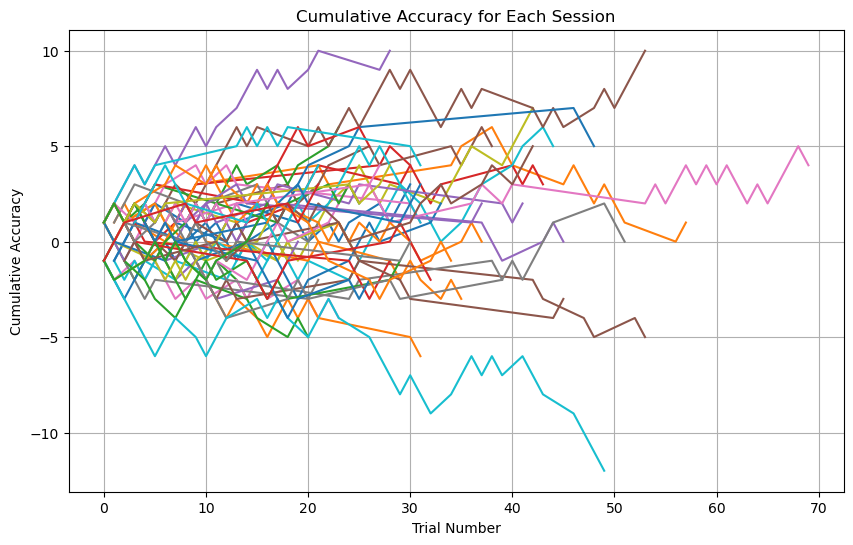

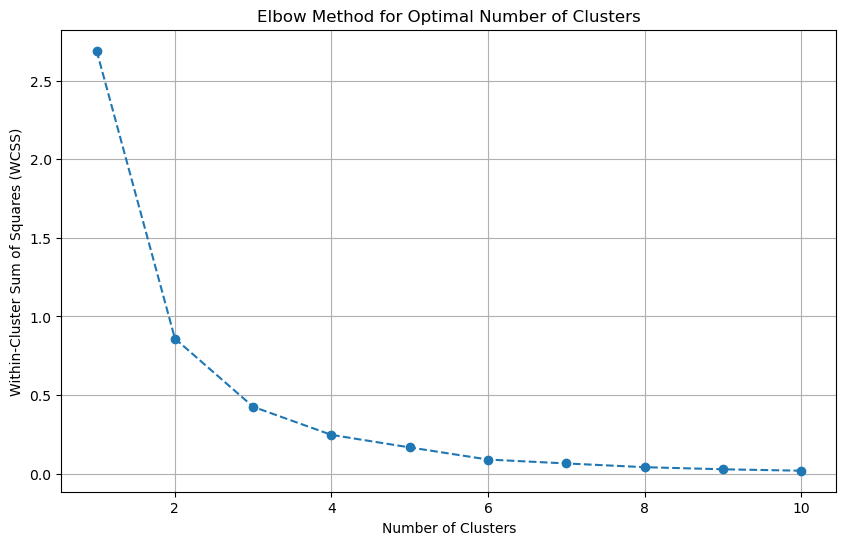

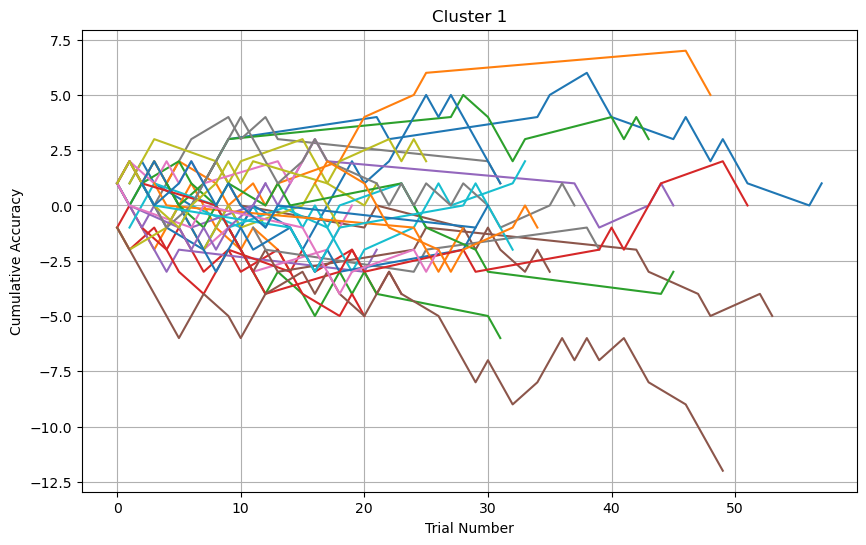

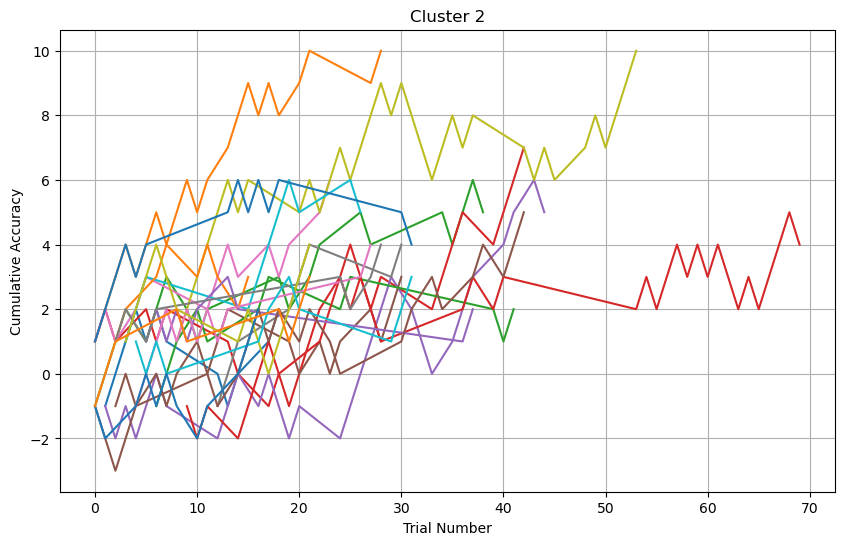

Cluster 1: 1, 2, 3, 6, 7, 11, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 32, 33, 35, 37, 38, 39, 40, 41, 42, 43, 47, 51
Cluster 2: 0, 4, 5, 8, 9, 10, 12, 13, 15, 23, 29, 31, 34, 36, 44, 45, 46, 48, 49, 50, 52, 53


In [43]:
# Cumulative accuracy over trials for each session
# For each correct trial, it adds 1, and for each incorrect trial, it subtracts 1

warnings.filterwarnings("ignore")
cumulative_accuracy_data = []

for session, session_data in data.groupby('session'):
    cumulative_accuracy = 0
    for index, trial in session_data.iterrows():
        if trial['accuracy'] == 1:
            cumulative_accuracy += 1
        else:
            cumulative_accuracy -= 1
        cumulative_accuracy_data.append({'session': session, 'trialno': trial['trialno'], 'cumulative_accuracy': cumulative_accuracy})

cumulative_accuracy_df = pd.DataFrame(cumulative_accuracy_data)

plt.figure(figsize=(10, 6))
for session, session_data in cumulative_accuracy_df.groupby('session'):
    plt.plot(session_data['trialno'], session_data['cumulative_accuracy'], label=f'Session {session}')

plt.xlabel('Trial Number')
plt.ylabel('Cumulative Accuracy')
plt.title('Cumulative Accuracy for Each Session')
#plt.legend()
plt.grid(True)
plt.show()

# Calculating slope for each session
slope_data = []

for session, session_data in cumulative_accuracy_df.groupby('session'):
    trial_numbers = session_data['trialno']
    cumulative_accuracies = session_data['cumulative_accuracy']
    slopes = np.diff(cumulative_accuracies) / np.diff(trial_numbers)
    avg_slope = np.mean(slopes)
    slope_data.append({'session': session, 'average_slope': avg_slope})

slope_df = pd.DataFrame(slope_data)

# Clustering babies according to their tendency

wcss = []
for num_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(slope_df[['average_slope']])
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

optimal_num_clusters = 2
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
clusters = kmeans.fit_predict(slope_df[['average_slope']])

for i in range(optimal_num_clusters):
    plt.figure(figsize=(10, 6))
    cluster_sessions = slope_df[clusters == i]['session']
    for session in cluster_sessions:
        session_data = cumulative_accuracy_df[cumulative_accuracy_df['session'] == session]
        plt.plot(session_data['trialno'], session_data['cumulative_accuracy'], label=f'Session {session}')
    plt.xlabel('Trial Number')
    plt.ylabel('Cumulative Accuracy')
    plt.title(f'Cluster {i+1}')
    #plt.legend()
    plt.grid(True)
    plt.show()

for i in range(optimal_num_clusters):
    sessions_in_cluster = slope_df.loc[clusters == i, 'session']
    print(f"Cluster {i+1}: {', '.join(map(str, sessions_in_cluster))}")

In [45]:
# Initialize cumulative accuracy column
data['cumulative_accuracy'] = 0

# Initialize cumulative accuracy column
data['cumulative_accuracy'] = 0

# Iterate over each session
for session, session_data in data.groupby('session'):
    # Initialize cumulative accuracy for the session
    cumulative_accuracy = 0
    # Iterate over each trial in the session
    for index, trial in session_data.iterrows():
        # Reset cumulative accuracy to 0 at the beginning of each session
        if index == session_data.index[0]:
            cumulative_accuracy = 0
        # Update cumulative accuracy based on trial accuracy
        if trial['accuracy'] == 1:
            cumulative_accuracy += 1
        else:
            cumulative_accuracy -= 1
        # Assign cumulative accuracy to the corresponding row in the DataFrame
        data.at[index, 'cumulative_accuracy'] = cumulative_accuracy

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print DataFrame with 'session' and 'cumulative_accuracy' columns
print(data[['session', 'cumulative_accuracy']])

     session  cumulative_accuracy
0          0                   -1
1          0                    0
2          0                    1
3          0                    2
4          0                    1
5          0                    2
6          0                    1
7          0                    0
8          0                   -1
9          0                    0
10         0                    1
11         0                    2
12         1                    1
13         1                    2
14         1                    1
15         1                    0
16         1                    1
17         1                    2
18         1                    3
19         1                    4
20         1                    3
21         1                    4
22         1                    5
23         1                    6
24         1                    5
25         1                    4
26         1                    3
27         1                    4
28         1  

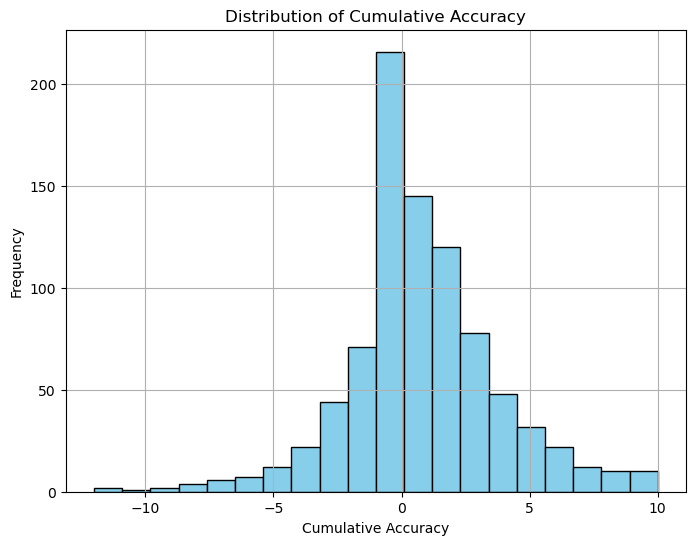

Data does not look normally distributed (reject H0)
Best fit distribution: gamma


In [46]:
# Distribution of Cumulative Accuracy

cum_accuracy_data = data['cumulative_accuracy']

plt.figure(figsize=(8, 6))
plt.hist(cum_accuracy_data, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Cumulative Accuracy')
plt.xlabel('Cumulative Accuracy')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Check distribution
stat, p = shapiro(cum_accuracy_data)

alpha = 0.05
if p > alpha:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

distribution_names = ['gamma', 'beta', 'expon', 'lognorm', 'pareto', 'weibull_min', 'weibull_max']
best_fit_name = None
best_fit_params = {}
best_kstest_stat = np.inf

for distribution_name in distribution_names:
    distribution = getattr(stats, distribution_name)
    params = distribution.fit(cum_accuracy_data)
    kstest_stat, _ = stats.kstest(cum_accuracy_data, distribution_name, args=params)
    if kstest_stat < best_kstest_stat:
        best_fit_name = distribution_name
        best_fit_params = params
        best_kstest_stat = kstest_stat
print(f"Best fit distribution: {best_fit_name}")

## Modeling if children get better or worse over time

In [56]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: cumulative_accuracy
# Distribution: gamma

data.dropna(inplace=True)

data['trialno'] = data['trialno'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

data['transformed_cumulative_accuracy'] = np.log(data['cumulative_accuracy'] + 0.001) # Transform cumulative_accuracy to fit a Gamma distribution

formula = 'transformed_cumulative_accuracy ~ trialno + np.power(trialno, 2) + (trialno | session)' # Quadratic term for trialno (non-linearity) #random slope and random intercept

mixed_model = sm.MixedLM.from_formula(formula, data=data, groups=data['session'])

result = mixed_model.fit()

print(result.summary())

                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: transformed_cumulative_accuracy
No. Observations: 430     Method:             REML                           
No. Groups:       49      Scale:              6.7847                         
Min. group size:  1       Log-Likelihood:     -1071.1035                     
Max. group size:  32      Converged:          Yes                            
Mean group size:  8.8                                                        
-------------------------------------------------------------------------------
                           Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-------------------------------------------------------------------------------
Intercept                  -1.990      0.503   -3.956   0.000   -2.976   -1.004
trialno                     0.068      0.015    4.435   0.000    0.038    0.098
np.power(trialno, 2)        0.001      0.002    0.621   0.535   -0.003    

In [63]:
# Generalized Estimating Equations
# Method: GEE
# Variable: accuracy
# Distribution: binomial

data.dropna(inplace=True)

data['trialno'] = data['trialno'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

formula = 'accuracy ~ trialno + np.power(trialno, 2) + (trialno | session)'

gee_model = sm.GEE.from_formula(formula, groups=data['session'], data=data, family=sm.families.Binomial())

# Fit the model
result = gee_model.fit()

# Print summary
print(result.summary())

                               GEE Regression Results                              
Dep. Variable:                    accuracy   No. Observations:                  430
Model:                                 GEE   No. clusters:                       49
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                  32
Family:                           Binomial   Mean cluster size:                 8.8
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Mon, 29 Apr 2024   Scale:                           1.000
Covariance type:                    robust   Time:                         20:56:18
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.8711      0.137      6.341      0.000  

In [66]:
# Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: accuracy
# Distribution: binomial #NOT REALLY ACCOUNTING FOR THIS

data.dropna(inplace=True)

data['trialno'] = data['trialno'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

formula = 'accuracy ~ trialno + np.power(trialno, 2) + (trialno | session)'

# Fit the mixed effects model
mixed_model = sm.MixedLM.from_formula(formula, groups=data['session'], data=data)

# Fit the model
result_mixed = mixed_model.fit()

# Print summary
print(result_mixed.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   accuracy 
No. Observations:     430       Method:               REML     
No. Groups:           49        Scale:                0.2306   
Min. group size:      1         Log-Likelihood:       -317.7135
Max. group size:      32        Converged:            No       
Mean group size:      8.8                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.714    0.055 13.102 0.000  0.607  0.821
trialno              -0.001    0.002 -0.711 0.477 -0.005  0.003
np.power(trialno, 2) -0.000    0.000 -0.794 0.427 -0.001  0.000
trialno | session    -0.002    0.002 -0.909 0.364 -0.005  0.002
Group Var             0.005                                    



In [77]:
pip install --upgrade pymc3

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip uninstall theano

  Using cached pymc3-3.11.5-py3-none-any.whl.metadata (14 kB)
  Using cached deprecat-2.1.1-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached numpy-1.22.1.zip (11.4 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
INFO: pip is looking at multiple versions of pymc3 to determine which version is compatible with other requirements. This could take a while.


In [74]:
import numpy as np
import pymc3 as pm

# Assuming 'data' is your DataFrame containing the data

data.dropna(inplace=True)

data['trialno'] = data['trialno'].astype('category').cat.codes
data['session'] = data['session'].astype('category').cat.codes

# Define the model
with pm.Model() as bayesian_model:
    # Fixed effects coefficients
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)
    
    # Random effects for session
    sigma_session = pm.HalfNormal('sigma_session', sigma=1)
    session_random_effects = pm.Normal('session_random_effects', mu=0, sigma=sigma_session, shape=len(data['session'].unique()))
    
    # Linear combination
    linear_combination = (
        beta0 +
        beta1 * data['trialno'] +
        beta2 * np.power(data['trialno'], 2) +
        session_random_effects[data['session']]
    )
    
    # Logistic transformation for binomial response
    p = pm.math.invlogit(linear_combination)
    
    # Binomial likelihood
    observation = pm.Binomial('observation', n=1, p=p, observed=data['accuracy'].values)
    
    # Sampling
    trace = pm.sample(1000, tune=1000, cores=1)  # Adjust as needed

# Summarize the results
summary = pm.summary(trace)
print(summary)



You can find the C code in this temporary file: C:\Users\I587504\AppData\Local\Temp\theano_compilation_error_nds36nxm


AttributeError: partially initialized module 'theano' has no attribute 'gof' (most likely due to a circular import)